In [1]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append(str(Path(".").resolve().parent))

In [4]:
IS_INTERACTIVE = False
try:
    get_ipython()  # type: ignore
except NameError: pass
else: IS_INTERACTIVE = True
IS_INTERACTIVE

True

In [5]:
p = ArgumentParser()
p.add_argument("natural_language_stimulus_path", type=Path)

_StoreAction(option_strings=[], dest='natural_language_stimulus_path', nargs=None, const=None, default=None, type=<class 'pathlib.Path'>, choices=None, required=True, help=None, metavar=None)

In [6]:
if IS_INTERACTIVE:
    # args = Namespace(natural_language_stimulus_path=Path("gillis2021/DKZ_1.pkl"))
    args = Namespace(natural_language_stimulus_path=Path("/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/work/b7/bbe1971fd234f532b304357a21f958/DKZ_1.pkl"))
else:
    args = p.parse_args()

---

In [7]:
with args.natural_language_stimulus_path.open("rb") as f:
    stim = pickle.load(f)

In [8]:
print("Num words:", len(stim.word_lengths))
print("Num candidates:", stim.p_candidates.shape[-1])

Num words: 2190
Num candidates: 20000


Text(0.5, 0, 'Ground-truth word log-probability')

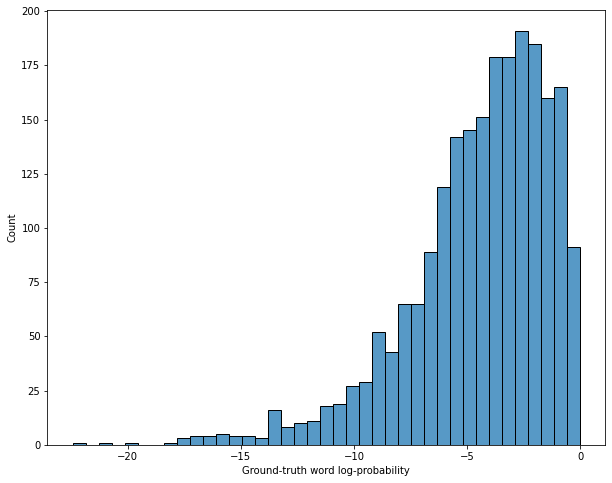

In [9]:
gt_word_probs = stim.p_candidates[:, 0].numpy()

plt.subplots(figsize=(10, 8))
sns.histplot(gt_word_probs)
plt.xlabel("Ground-truth word log-probability")

In [10]:
candidate_phonemes = stim.candidate_phonemes

In [11]:
candidate_lengths = (candidate_phonemes != stim.pad_phoneme_id).sum(dim=2)
gt_lengths, candidate_lengths = candidate_lengths[:, 0], candidate_lengths[:, 1:]
candidate_mean_lengths = candidate_lengths.float().mean(dim=1)

<AxesSubplot:title={'center':'Candidate lengths (in phonemes)'}, ylabel='Count'>

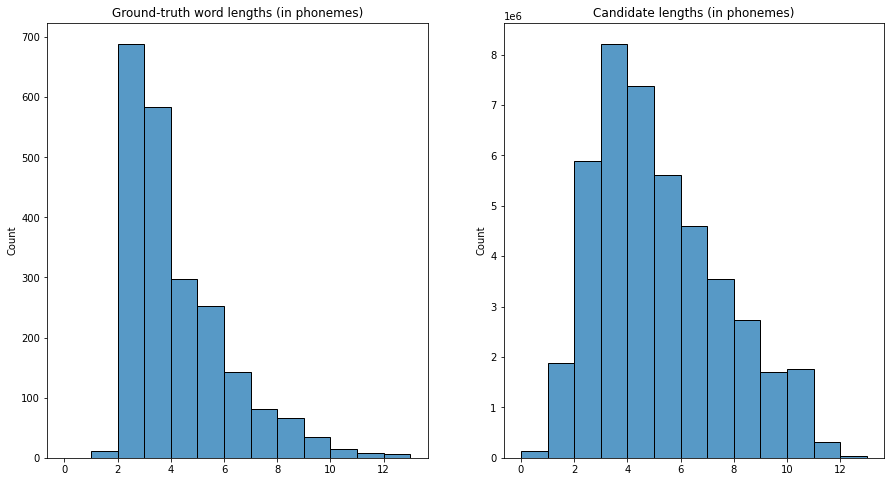

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.set_title("Ground-truth word lengths (in phonemes)")
ax2.set_title("Candidate lengths (in phonemes)")

max_length = max(candidate_lengths.max(), gt_lengths.max())
sns.histplot(gt_lengths.numpy(), bins=np.arange(max_length), ax=ax1)
sns.histplot(candidate_lengths.flatten().numpy(), bins=np.arange(max_length), ax=ax2)

In [13]:
# For each candidate, is it a cohort competitor with ground truth?
# Compute this in batches because it's expensive
max_num_phonemes = candidate_phonemes.shape[2]
is_cohort_competitor = []
batch_size = 256
for i in trange(0, candidate_phonemes.shape[0] + batch_size, batch_size):
    batch = candidate_phonemes[i:i+batch_size]
    if len(batch) == 0:
        break
        
    is_cohort_competitor.append(
        (batch[:, 1:] == batch[:, :1]).cumsum(dim=2) == torch.arange(1, max_num_phonemes + 1))
is_cohort_competitor = torch.concat(is_cohort_competitor, dim=0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# plt.title("Fraction of candidates which are incremental cohort competitors, by phoneme position")
# sns.lineplot(data=pd.DataFrame(is_cohort_competitor.reshape(-1, max_num_phonemes).numpy()).melt(var_name="phoneme", value_name="is_competitor"),
#              x="phoneme", y="is_competitor", ci=None)

In [15]:
print("Percentage of words which have a candidate which is a cohort competitor for at least one phoneme:",
      is_cohort_competitor.any(dim=2).any(dim=1).float().mean().item() * 100)

Percentage of words which have a candidate which is a cohort competitor for at least one phoneme: 100.0


In [16]:
print("Percentage of words which have a candidate which is a cohort competitor at phoneme X:\n",
      pd.DataFrame(is_cohort_competitor.any(dim=1).float().mean(dim=0).numpy() * 100))

Percentage of words which have a candidate which is a cohort competitor at phoneme X:
              0
0   100.000000
1    98.721466
2    94.748863
3    85.707764
4    80.456619
5    77.305939
6    76.073059
7    75.205482
8    74.794518
9    74.657532
10   74.657532
11   74.611870
12   74.611870
13   74.611870


Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort: 2.9873704988858663e-05


<AxesSubplot:>

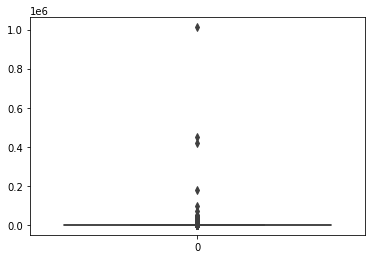

In [17]:
candidate_competitors = is_cohort_competitor.any(dim=2)
gt_probability_ratios = stim.p_candidates[:, 1:].exp() / stim.p_candidates[:, :1].exp()

print("Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort:", 
      gt_probability_ratios[candidate_competitors].median().item())
sns.boxplot(data=gt_probability_ratios[candidate_competitors].numpy())

In [ ]:
def visualize_candidates(word_idx):
    all_cands = stim.get_candidate_strs(word_idx)
    competitor_mask = [np.inf] + is_cohort_competitor[word_idx].sum(dim=1).tolist()
    return sorted([(count, cand) for cand, count in zip(all_cands, competitor_mask) if count > 0], reverse=True)

In [ ]:
visualize_candidates(0)

In [ ]:
candidate_phonemes[1, 0]

In [ ]:
visualize_candidates(10)